**Predicting Customer Churn Using RFM and CLV Metrics**
# Introduction
Customer retention is a key focus for businesses aiming to maximize profitability and sustain long-term growth. It is widely known that retaining an existing customer is significantly more cost-effective than acquiring a new one. However, customer churn — when a customer stops doing business with a company — remains a persistent challenge.

In this project, we aim to predict whether a customer is likely to churn using important customer behavior indicators such as:

Recency – How recently a customer made a purchase.

Frequency – How often they make purchases.

Monetary – How much money they spend.

Customer Lifetime Value (CLV) – An estimate of the total worth of a customer to a business over the duration of their relationship.

By training machine learning models on these features, we build a system that classifies customers into “churn” and “non-churn” categories. With this prediction, businesses can proactively target at-risk customers with retention strategies — such as personalized offers, loyalty programs, or engagement campaigns — thereby improving customer lifetime value and reducing revenue loss.

This work not only enables the prediction of churn, but also guides data-driven customer retention efforts, especially for high-value customers

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout





In [22]:
data = pd.read_csv('/content/drive/MyDrive/online_retail_II.csv', encoding='ISO-8859-1')


In [23]:
print(data.shape)
print(data.isna().sum())
print(data.duplicated().sum())
print(data.info())
print(data.columns)

(541910, 8)
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64
5268
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [24]:
df = data.dropna()
df.isna().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


In [25]:
df.describe()

,Quantity,Price,Customer ID
count,406830.000000,406830.000000,406830.000000
mean,12.061276,3.460507,15287.684160
std,248.693065,69.315080,1713.603074
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [26]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [27]:
# Convert Customer ID to string to prevent numeric issues
df['Customer ID'] = df['Customer ID'].astype(str)

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove canceled orders (they have Invoice starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Remove rows with non-positive Quantity or Price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]



<ipython-input-27-3923104916>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Customer ID'] = df['Customer ID'].astype(str)
<ipython-input-27-3923104916>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [28]:
# Assume latest date in dataset is the max InvoiceDate
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                      # Frequency
    'Price': lambda x: (x * df.loc[x.index, 'Quantity']).sum() # Monetary
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Price': 'Monetary'
}, inplace=True)

rfm.reset_index(inplace=True)
rfm.head()


,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [29]:
# Use the same snapshot date
churn_threshold = 90  # Define this based on domain knowledge

# Label churned customers
rfm['Churned'] = (rfm['Recency'] > churn_threshold).astype(int)
rfm.tail()


,Customer ID,Recency,Frequency,Monetary,Churned
4333,18280.0,278,1,180.60,1
4334,18281.0,181,1,80.82,1
4335,18282.0,8,2,178.05,0
4336,18283.0,4,16,2094.88,0
4337,18287.0,43,3,1837.28,0


In [30]:
# Already calculated as Monetary in RFM, you can rename for clarity
rfm['CLV'] = rfm['Monetary']
rfm.tail()

,Customer ID,Recency,Frequency,Monetary,Churned,CLV
4333,18280.0,278,1,180.60,1,180.60
4334,18281.0,181,1,80.82,1,80.82
4335,18282.0,8,2,178.05,0,178.05
4336,18283.0,4,16,2094.88,0,2094.88
4337,18287.0,43,3,1837.28,0,1837.28


In [31]:
# Total spend per customer
total_spend = df.groupby('Customer ID').apply(lambda x: (x['Quantity'] * x['Price']).sum())

# Number of unique orders
order_counts = df.groupby('Customer ID')['Invoice'].nunique()

# Average order value
avg_order_value = total_spend / order_counts

# Purchase frequency
total_customers = df['Customer ID'].nunique()
purchase_frequency = order_counts / total_customers

# Combine into a new CLV Series
clv = avg_order_value * purchase_frequency

# Make sure index is reset and merged into rfm
clv = clv.reset_index()
clv.columns = ['Customer ID', 'CLV']

# Merge into RFM
rfm = rfm.merge(clv, on='Customer ID', how='left')

rfm.isna().sum()


<ipython-input-31-580312700>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_spend = df.groupby('Customer ID').apply(lambda x: (x['Quantity'] * x['Price']).sum())


,0
Customer ID,0
Recency,0
Frequency,0
Monetary,0
Churned,0
CLV_x,0
CLV_y,0


In [32]:
# Drop the bad CLV column
rfm.drop(columns=['CLV_x'], inplace=True)

# Rename the correct CLV column
rfm.rename(columns={'CLV_y': 'CLV'}, inplace=True)

# Check it's clean
rfm.isna().sum()


,0
Customer ID,0
Recency,0
Frequency,0
Monetary,0
Churned,0
CLV,0


# OBJECTIVE ONE :: Predict whether a customer will churn or not using Recency, Frequency, Monetary, and optionally CLV

In [33]:
# Features (X) and Target (y)
X = rfm[['Recency', 'Frequency', 'Monetary', 'CLV']]
y = rfm['Churned']


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
# Initialize and train
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)

# Predict
y_pred = model_xgb.predict(X_test)

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:52:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       561
           1       1.00      1.00      1.00       307

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

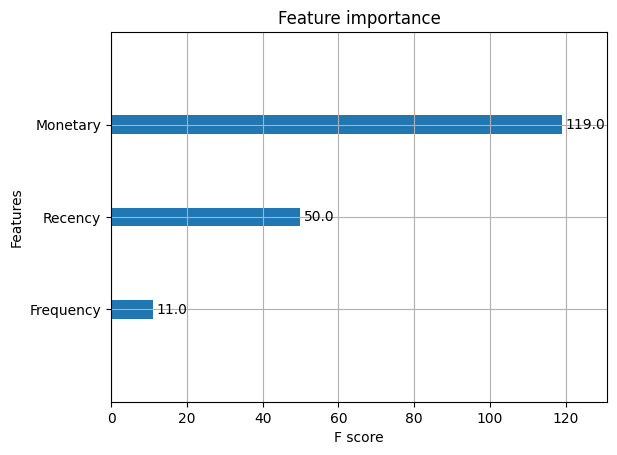

In [36]:
xgb.plot_importance(model_xgb)

In [37]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build model
model_keras = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


model_keras.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_ = model_keras.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate
loss, accuracy = model_keras.evaluate(X_test_scaled, y_test)
print(f"Keras Model Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9566 - loss: 0.4583 - val_accuracy: 0.9942 - val_loss: 0.1024
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9858 - loss: 0.0817 - val_accuracy: 0.9957 - val_loss: 0.0391
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9887 - loss: 0.0409 - val_accuracy: 0.9942 - val_loss: 0.0251
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9908 - loss: 0.0276 - val_accuracy: 1.0000 - val_loss: 0.0211
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9910 - loss: 0.0265 - val_accuracy: 1.0000 - val_loss: 0.0161
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9940 - loss: 0.0200 - val_accuracy: 1.0000 - val_loss: 0.0132
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9928 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 0.0113
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9967 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss:

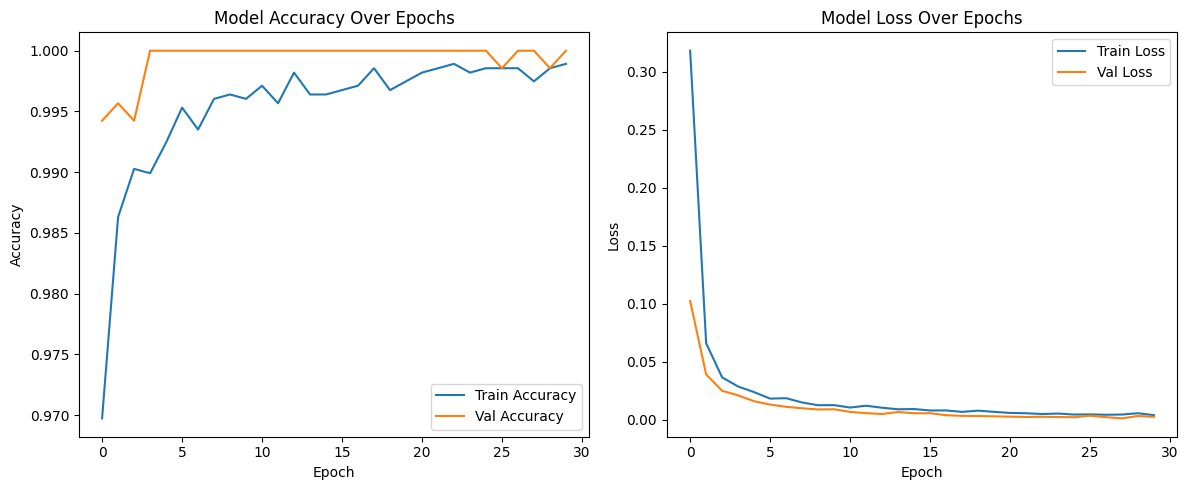

In [38]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_.history['accuracy'], label='Train Accuracy')
plt.plot(history_.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_.history['loss'], label='Train Loss')
plt.plot(history_.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [46]:
from sklearn.metrics import confusion_matrix
y_pred = (model_keras.predict(X_test_scaled) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[561   0]
 [  0 307]]


**Customers that would get churned**

In [39]:
# Predict churn probabilities (between 0 and 1)
y_probs = model_keras.predict(X_test_scaled)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [40]:
# Predict 1 if probability > 0.5
y_pred_class = (y_probs > 0.5).astype(int).flatten()


In [56]:
# Add predictions to X_test
X_test_pred = X_test.copy()
X_test_pred['Predicted_Churn'] = y_pred_class
X_test_pred['Customer ID'] = X_test_pred.index  # Add ID if needed

# Get customers predicted to churn
churned_customers = X_test_pred[X_test_pred['Predicted_Churn'] == 1]
active_customers = X_test_pred[X_test_pred['Predicted_Churn'] != 1]


In [57]:
churned_customers.head()
print(churned_customers.describe())
print(active_customers.describe())


          Recency   Frequency     Monetary         CLV  Predicted_Churn  \
count  307.000000  307.000000   307.000000  307.000000            307.0   
mean   213.638436    1.843648   623.430423    0.143714              1.0   
std     81.926774    1.419398   856.170187    0.197365              0.0   
min     92.000000    1.000000    25.500000    0.005878              1.0   
25%    141.000000    1.000000   207.360000    0.047801              1.0   
50%    203.000000    1.000000   380.500000    0.087713              1.0   
75%    276.500000    2.000000   686.515000    0.158256              1.0   
max    374.000000   13.000000  9864.260000    2.273919              1.0   

       Customer ID  
count   307.000000  
mean   2195.941368  
std    1312.933963  
min       8.000000  
25%    1009.500000  
50%    2238.000000  
75%    3338.000000  
max    4324.000000  
          Recency   Frequency       Monetary         CLV  Predicted_Churn  \
count  561.000000  561.000000     561.000000  561.000000  

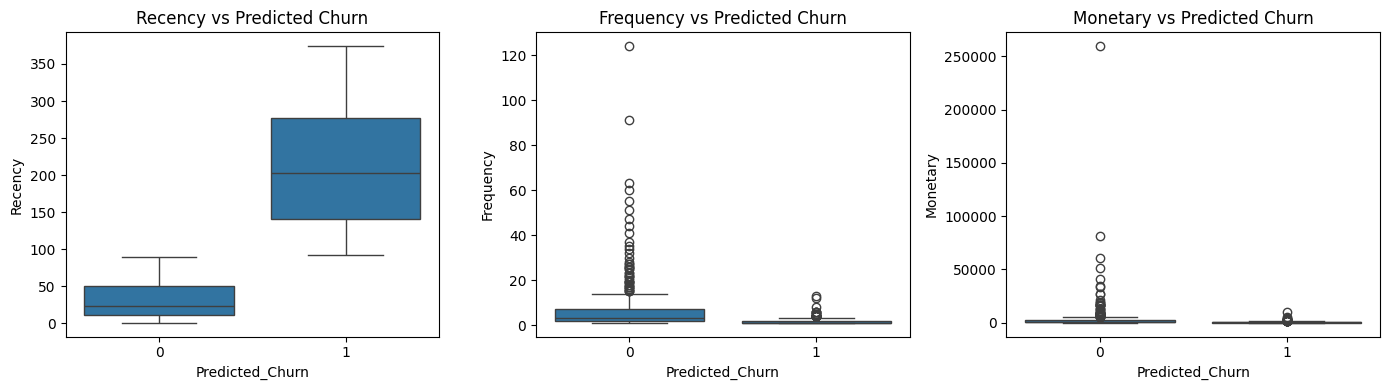

In [43]:
# Recreate full prediction DataFrame
X_test_pred = X_test.copy()
X_test_pred['Predicted_Churn'] = y_pred_class
X_test_pred['Customer ID'] = X_test_pred.index

# Combine with actual churn status for comparison (if available)
X_test_pred['Actual_Churn'] = y_test.values

# Compare churn vs not churn by Recency, Frequency, Monetary
plt.figure(figsize=(14, 4))

# Recency
plt.subplot(1, 3, 1)
sns.boxplot(data=X_test_pred, x='Predicted_Churn', y='Recency')
plt.title("Recency vs Predicted Churn")

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(data=X_test_pred, x='Predicted_Churn', y='Frequency')
plt.title("Frequency vs Predicted Churn")

# Monetary
plt.subplot(1, 3, 3)
sns.boxplot(data=X_test_pred, x='Predicted_Churn', y='Monetary')
plt.title("Monetary vs Predicted Churn")

plt.tight_layout()
plt.show()


**Churned Percentage**

In [52]:
# Number of customers predicted to churn
num_churned = (y_pred_class == 1).sum()
#print(num_churned.describe())


# Total number of customers in the test set
total_customers = len(y_pred_class)

# Churn percentage
churn_percentage = (num_churned / total_customers) * 100

print(f"Predicted Churn Rate: {churn_percentage:.2f}%")


Predicted Churn Rate: 35.37%


In [45]:
# Actual
actual_churned = (y_test == 1).sum()
actual_active = (y_test == 0).sum()

# Predicted
pred_churned = (y_pred_class == 1).sum()
pred_active = (y_pred_class == 0).sum()


# OBjective Two
Retain at least 70% of high-paying customers (high "Monetary" value) predicted to churn

In [62]:
# Attach predictions to X_test
X_test_copy = X_test.copy()
X_test_copy['Predicted_Label'] = y_pred_class
X_test_copy['Actual_Label'] = y_test.values  # optional

# Threshold for top 30% high-paying
monetary_threshold = X_test_copy['Monetary'].quantile(0.7)

# Filter high-paying churned predictions
high_value_churners = X_test_copy[
    (X_test_copy['Predicted_Label'] == 1) &
    (X_test_copy['Monetary'] >= monetary_threshold)
]

print(f"Number of high-value churners identified: {len(high_value_churners)}")


Number of high-value churners identified: 30


In [63]:
print(high_value_churners[['Recency', 'Frequency', 'Monetary']].describe())


          Recency  Frequency     Monetary
count   30.000000  30.000000    30.000000
mean   176.500000   3.700000  2472.631667
std     70.011206   2.854518  1736.967821
min     95.000000   1.000000  1384.250000
25%    130.500000   2.000000  1547.700000
50%    150.000000   3.000000  1821.860000
75%    204.500000   4.000000  2480.732500
max    358.000000  13.000000  9864.260000


In [64]:
def segment_customer(row):
    if row['Recency'] > X_test_copy['Recency'].median():
        return 'Long_Inactive'
    elif row['Frequency'] < X_test_copy['Frequency'].median():
        return 'Low_Engagement'
    else:
        return 'At_Risk_Loyalist'

high_value_churners['Segment'] = high_value_churners.apply(segment_customer, axis=1)


<ipython-input-64-2031079862>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_churners['Segment'] = high_value_churners.apply(segment_customer, axis=1)


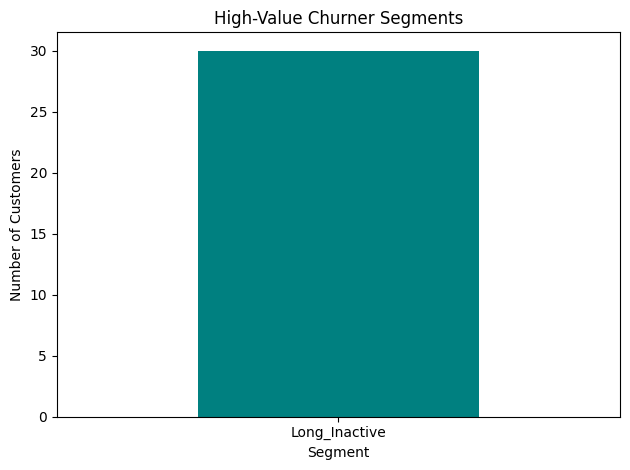

In [65]:
import matplotlib.pyplot as plt

high_value_churners['Segment'].value_counts().plot(kind='bar', color='teal')
plt.title("High-Value Churner Segments")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
